In [1]:
#Librairie

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
pip install lightgbm

     ---------------------------------------- 1.0/1.0 MB 22.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
from lightgbm import LGBMClassifier

## Prétraitement des données 

In [4]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


In [5]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(r"C:\Users\jason\OneDrive\Bureau\big J\Openclassroom\Projet 7\Projet+Mise+en+prod+-+home-credit-default-risk\application_train.csv", nrows= num_rows)
    test_df = pd.read_csv(r"C:\Users\jason\OneDrive\Bureau\big J\Openclassroom\Projet 7\Projet+Mise+en+prod+-+home-credit-default-risk\application_test.csv", nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [6]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(r"C:\Users\jason\OneDrive\Bureau\big J\Openclassroom\Projet 7\Projet+Mise+en+prod+-+home-credit-default-risk\bureau.csv", nrows = num_rows)
    bb = pd.read_csv(r"C:\Users\jason\OneDrive\Bureau\big J\Openclassroom\Projet 7\Projet+Mise+en+prod+-+home-credit-default-risk\bureau_balance.csv", nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [7]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(r"C:\Users\jason\OneDrive\Bureau\big J\Openclassroom\Projet 7\Projet+Mise+en+prod+-+home-credit-default-risk\previous_application.csv", nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg


In [8]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(r"C:\Users\jason\OneDrive\Bureau\big J\Openclassroom\Projet 7\Projet+Mise+en+prod+-+home-credit-default-risk\POS_CASH_balance.csv", nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [9]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(r"C:\Users\jason\OneDrive\Bureau\big J\Openclassroom\Projet 7\Projet+Mise+en+prod+-+home-credit-default-risk\installments_payments.csv", nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [10]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(r"C:\Users\jason\OneDrive\Bureau\big J\Openclassroom\Projet 7\Projet+Mise+en+prod+-+home-credit-default-risk\credit_card_balance.csv", nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [11]:
# LightGBM GBDT with KFold or Stratified KFold

import re

def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in df.columns}
    new_n_list = list(new_names.values())
    # [LightGBM] Feature appears more than one time.
    new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
    df = df.rename(columns=new_names)
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv('submission_file_name', index= False)
    display_importances(feature_importance_df)
    return feature_importance_df


In [12]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [13]:
data = application_train_test(num_rows = None, nan_as_category = False)

Train samples: 307511, test samples: 48744


In [14]:
data

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,0,1,0,1,0,0.067329,0.498036,202500.0,0.121978,0.060749
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,0,0,0,1,0,0.070862,0.208736,135000.0,0.132217,0.027598
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0.011814,0.500000,67500.0,0.100000,0.050000
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0.159905,0.431748,67500.0,0.219900,0.094941
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0.152418,0.236842,121500.0,0.179963,0.042623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,48739,456221,NaN,1,0,0,0,121500.0,412560.0,17473.5,...,0,0,0,0,0,0.258838,0.294503,121500.0,0.143815,0.042354
356251,48740,456222,NaN,1,0,1,2,157500.0,622413.0,31909.5,...,0,0,0,0,0,0.102718,0.253047,39375.0,0.202600,0.051267
356252,48741,456223,NaN,1,1,0,1,202500.0,315000.0,33205.5,...,0,1,0,1,0,0.190742,0.642857,67500.0,0.163978,0.105414
356253,48742,456224,NaN,0,0,1,0,225000.0,450000.0,25128.0,...,1,0,0,1,0,0.195518,0.500000,112500.0,0.111680,0.055840


In [15]:
data.isna().sum()

index                      0
SK_ID_CURR                 0
TARGET                 48744
CODE_GENDER                0
FLAG_OWN_CAR               0
                       ...  
DAYS_EMPLOYED_PERC     64648
INCOME_CREDIT_PERC         0
INCOME_PER_PERSON          2
ANNUITY_INCOME_PERC       36
PAYMENT_RATE              36
Length: 248, dtype: int64

Starting LightGBM. Train shape: (307507, 248), test shape: (48744, 248)


C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument i

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.77528	training's binary_logloss: 0.241289	valid_1's auc: 0.761409	valid_1's binary_logloss: 0.248122
[400]	training's auc: 0.793725	training's binary_logloss: 0.234911	valid_1's auc: 0.768033	valid_1's binary_logloss: 0.245666
[600]	training's auc: 0.805833	training's binary_logloss: 0.230859	valid_1's auc: 0.769743	valid_1's binary_logloss: 0.245031
[800]	training's auc: 0.816214	training's binary_logloss: 0.227277	valid_1's auc: 0.770669	valid_1's binary_logloss: 0.244697
[1000]	training's auc: 0.825509	training's binary_logloss: 0.223994	valid_1's auc: 0.771102	valid_1's binary_logloss: 0.244593
[1200]	training's auc: 0.833814	training's binary_logloss: 0.220986	valid_1's auc: 0.771176	valid_1's binary_logloss: 0.244555
Fold  1 AUC : 0.771249


C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument i

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.776187	training's binary_logloss: 0.241309	valid_1's auc: 0.758294	valid_1's binary_logloss: 0.247944
[400]	training's auc: 0.794059	training's binary_logloss: 0.235078	valid_1's auc: 0.76506	valid_1's binary_logloss: 0.245561
[600]	training's auc: 0.805712	training's binary_logloss: 0.231169	valid_1's auc: 0.767132	valid_1's binary_logloss: 0.244869
[800]	training's auc: 0.815807	training's binary_logloss: 0.227657	valid_1's auc: 0.76789	valid_1's binary_logloss: 0.244582
[1000]	training's auc: 0.825243	training's binary_logloss: 0.224384	valid_1's auc: 0.768072	valid_1's binary_logloss: 0.244465
Fold  2 AUC : 0.768151


C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument i

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.77599	training's binary_logloss: 0.242554	valid_1's auc: 0.756416	valid_1's binary_logloss: 0.243236
[400]	training's auc: 0.794003	training's binary_logloss: 0.236177	valid_1's auc: 0.763378	valid_1's binary_logloss: 0.241044
[600]	training's auc: 0.806204	training's binary_logloss: 0.232057	valid_1's auc: 0.765074	valid_1's binary_logloss: 0.24049
[800]	training's auc: 0.816229	training's binary_logloss: 0.228535	valid_1's auc: 0.766071	valid_1's binary_logloss: 0.24015
[1000]	training's auc: 0.825476	training's binary_logloss: 0.225239	valid_1's auc: 0.766303	valid_1's binary_logloss: 0.240056
[1200]	training's auc: 0.834025	training's binary_logloss: 0.222163	valid_1's auc: 0.766502	valid_1's binary_logloss: 0.239997
[1400]	training's auc: 0.84185	training's binary_logloss: 0.219272	valid_1's auc: 0.766456	valid_1's binary_logloss: 0.240036
Fold  

C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument i

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.775937	training's binary_logloss: 0.241486	valid_1's auc: 0.757866	valid_1's binary_logloss: 0.247202
[400]	training's auc: 0.793179	training's binary_logloss: 0.235429	valid_1's auc: 0.764445	valid_1's binary_logloss: 0.244966
[600]	training's auc: 0.805698	training's binary_logloss: 0.231197	valid_1's auc: 0.766309	valid_1's binary_logloss: 0.244397
[800]	training's auc: 0.816393	training's binary_logloss: 0.227503	valid_1's auc: 0.76746	valid_1's binary_logloss: 0.244059
[1000]	training's auc: 0.825554	training's binary_logloss: 0.224288	valid_1's auc: 0.76807	valid_1's binary_logloss: 0.243906
[1200]	training's auc: 0.83339	training's binary_logloss: 0.221466	valid_1's auc: 0.768129	valid_1's binary_logloss: 0.243909
Fold  4 AUC : 0.768114


C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument i

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.775392	training's binary_logloss: 0.241903	valid_1's auc: 0.760079	valid_1's binary_logloss: 0.245902
[400]	training's auc: 0.793191	training's binary_logloss: 0.235648	valid_1's auc: 0.767332	valid_1's binary_logloss: 0.243419
[600]	training's auc: 0.805525	training's binary_logloss: 0.231462	valid_1's auc: 0.769635	valid_1's binary_logloss: 0.242689
[800]	training's auc: 0.816394	training's binary_logloss: 0.227773	valid_1's auc: 0.770492	valid_1's binary_logloss: 0.242434
[1000]	training's auc: 0.82599	training's binary_logloss: 0.224367	valid_1's auc: 0.770757	valid_1's binary_logloss: 0.242332
[1200]	training's auc: 0.834061	training's binary_logloss: 0.22144	valid_1's auc: 0.770874	valid_1's binary_logloss: 0.242313
[1400]	training's auc: 0.841748	training's binary_logloss: 0.218587	valid_1's auc: 0.770953	valid_1's binary_logloss: 0.242328
Fold

,feature,importance,fold
0,CODE_GENDER,324,1
1,FLAG_OWN_CAR,12,1
2,FLAG_OWN_REALTY,73,1
3,CNT_CHILDREN,48,1
4,AMT_INCOME_TOTAL,490,1
...,...,...,...
240,DAYS_EMPLOYED_PERC,1242,5
241,INCOME_CREDIT_PERC,762,5
242,INCOME_PER_PERSON,631,5
243,ANNUITY_INCOME_PERC,1030,5


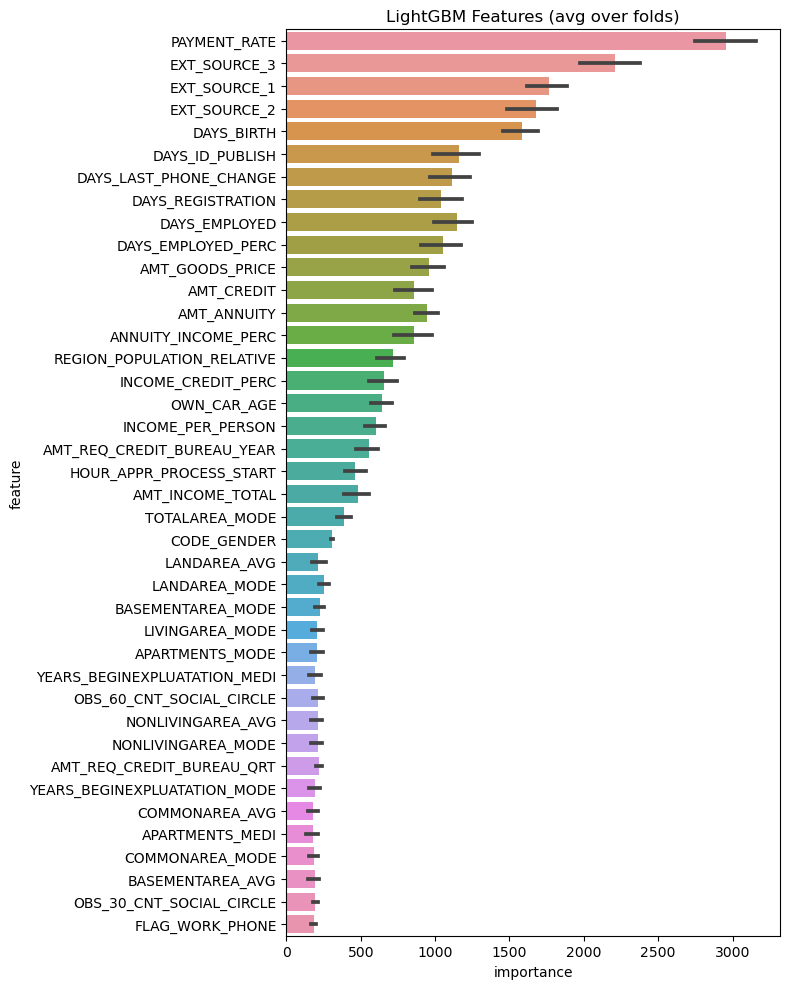

In [16]:
kfold_lightgbm(data, 5, stratified = False, debug= False)

Starting LightGBM. Train shape: (307507, 248), test shape: (48744, 248)


C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument i

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.77528	training's binary_logloss: 0.241289	valid_1's auc: 0.761409	valid_1's binary_logloss: 0.248122
[400]	training's auc: 0.793725	training's binary_logloss: 0.234911	valid_1's auc: 0.768033	valid_1's binary_logloss: 0.245666
[600]	training's auc: 0.805833	training's binary_logloss: 0.230859	valid_1's auc: 0.769743	valid_1's binary_logloss: 0.245031
[800]	training's auc: 0.816214	training's binary_logloss: 0.227277	valid_1's auc: 0.770669	valid_1's binary_logloss: 0.244697
[1000]	training's auc: 0.825509	training's binary_logloss: 0.223994	valid_1's auc: 0.771102	valid_1's binary_logloss: 0.244593
[1200]	training's auc: 0.833814	training's binary_logloss: 0.220986	valid_1's auc: 0.771176	valid_1's binary_logloss: 0.244555
Fold  1 AUC : 0.771249


C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument i

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.776187	training's binary_logloss: 0.241309	valid_1's auc: 0.758294	valid_1's binary_logloss: 0.247944
[400]	training's auc: 0.794059	training's binary_logloss: 0.235078	valid_1's auc: 0.76506	valid_1's binary_logloss: 0.245561
[600]	training's auc: 0.805712	training's binary_logloss: 0.231169	valid_1's auc: 0.767132	valid_1's binary_logloss: 0.244869
[800]	training's auc: 0.815807	training's binary_logloss: 0.227657	valid_1's auc: 0.76789	valid_1's binary_logloss: 0.244582
[1000]	training's auc: 0.825243	training's binary_logloss: 0.224384	valid_1's auc: 0.768072	valid_1's binary_logloss: 0.244465
Fold  2 AUC : 0.768151


C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument i

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.77599	training's binary_logloss: 0.242554	valid_1's auc: 0.756416	valid_1's binary_logloss: 0.243236
[400]	training's auc: 0.794003	training's binary_logloss: 0.236177	valid_1's auc: 0.763378	valid_1's binary_logloss: 0.241044
[600]	training's auc: 0.806204	training's binary_logloss: 0.232057	valid_1's auc: 0.765074	valid_1's binary_logloss: 0.24049
[800]	training's auc: 0.816229	training's binary_logloss: 0.228535	valid_1's auc: 0.766071	valid_1's binary_logloss: 0.24015
[1000]	training's auc: 0.825476	training's binary_logloss: 0.225239	valid_1's auc: 0.766303	valid_1's binary_logloss: 0.240056
[1200]	training's auc: 0.834025	training's binary_logloss: 0.222163	valid_1's auc: 0.766502	valid_1's binary_logloss: 0.239997
[1400]	training's auc: 0.84185	training's binary_logloss: 0.219272	valid_1's auc: 0.766456	valid_1's binary_logloss: 0.240036
Fold  

C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument i

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.775937	training's binary_logloss: 0.241486	valid_1's auc: 0.757866	valid_1's binary_logloss: 0.247202
[400]	training's auc: 0.793179	training's binary_logloss: 0.235429	valid_1's auc: 0.764445	valid_1's binary_logloss: 0.244966
[600]	training's auc: 0.805698	training's binary_logloss: 0.231197	valid_1's auc: 0.766309	valid_1's binary_logloss: 0.244397
[800]	training's auc: 0.816393	training's binary_logloss: 0.227503	valid_1's auc: 0.76746	valid_1's binary_logloss: 0.244059
[1000]	training's auc: 0.825554	training's binary_logloss: 0.224288	valid_1's auc: 0.76807	valid_1's binary_logloss: 0.243906
[1200]	training's auc: 0.83339	training's binary_logloss: 0.221466	valid_1's auc: 0.768129	valid_1's binary_logloss: 0.243909
Fold  4 AUC : 0.768114


C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument i

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.775392	training's binary_logloss: 0.241903	valid_1's auc: 0.760079	valid_1's binary_logloss: 0.245902
[400]	training's auc: 0.793191	training's binary_logloss: 0.235648	valid_1's auc: 0.767332	valid_1's binary_logloss: 0.243419
[600]	training's auc: 0.805525	training's binary_logloss: 0.231462	valid_1's auc: 0.769635	valid_1's binary_logloss: 0.242689
[800]	training's auc: 0.816394	training's binary_logloss: 0.227773	valid_1's auc: 0.770492	valid_1's binary_logloss: 0.242434
[1000]	training's auc: 0.82599	training's binary_logloss: 0.224367	valid_1's auc: 0.770757	valid_1's binary_logloss: 0.242332
[1200]	training's auc: 0.834061	training's binary_logloss: 0.22144	valid_1's auc: 0.770874	valid_1's binary_logloss: 0.242313
[1400]	training's auc: 0.841748	training's binary_logloss: 0.218587	valid_1's auc: 0.770953	valid_1's binary_logloss: 0.242328
Fold

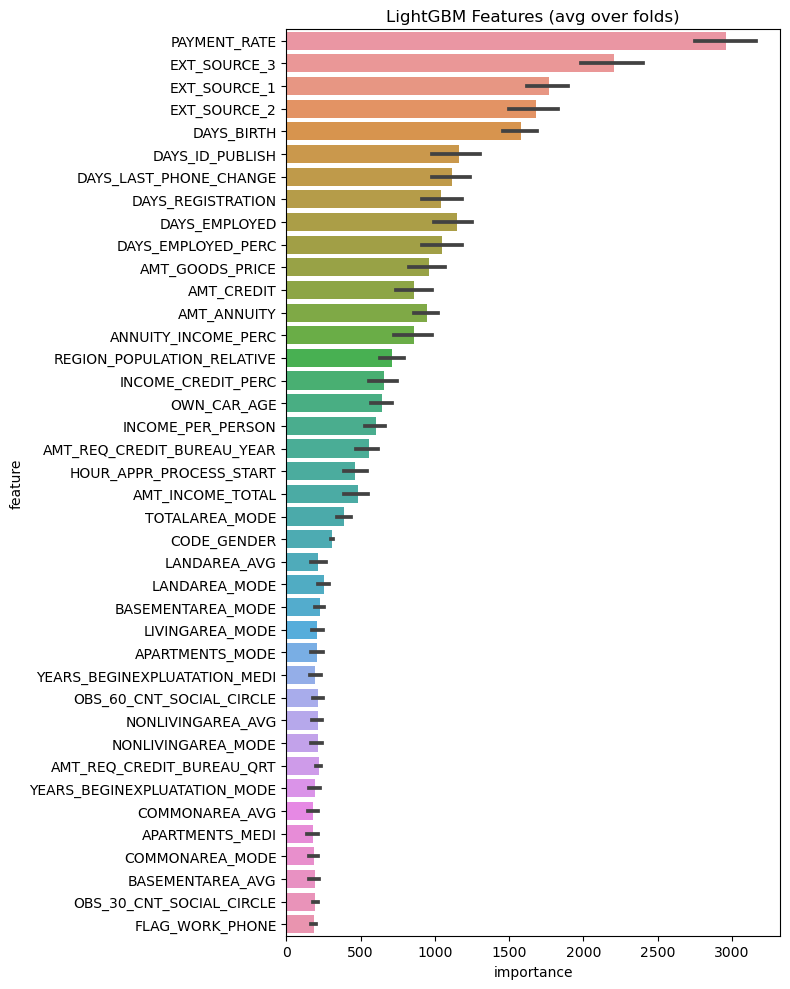

In [18]:
feature_importance_df=kfold_lightgbm(data, 5, stratified = False, debug= False)

In [19]:
feature_importance_df['importance'].mean()

141.31591836734694

In [21]:
feature_importance_df.loc[feature_importance_df['importance']>141]

,feature,importance,fold
0,CODE_GENDER,324,1
4,AMT_INCOME_TOTAL,490,1
5,AMT_CREDIT,805,1
6,AMT_ANNUITY,924,1
7,AMT_GOODS_PRICE,916,1
...,...,...,...
240,DAYS_EMPLOYED_PERC,1242,5
241,INCOME_CREDIT_PERC,762,5
242,INCOME_PER_PERSON,631,5
243,ANNUITY_INCOME_PERC,1030,5


Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 21s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 35s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 19s
Installments payments df shape: (339587, 26)
Process installments payments - done in 33s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 16s
Starting LightGBM. Train shape: (307507, 798), test shape: (48744, 798)


C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument i

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.803491	training's binary_logloss: 0.231992	valid_1's auc: 0.774499	valid_1's binary_logloss: 0.244831
[400]	training's auc: 0.829173	training's binary_logloss: 0.221118	valid_1's auc: 0.783877	valid_1's binary_logloss: 0.241055
[600]	training's auc: 0.846138	training's binary_logloss: 0.214031	valid_1's auc: 0.787004	valid_1's binary_logloss: 0.239953
[800]	training's auc: 0.859614	training's binary_logloss: 0.208255	valid_1's auc: 0.788082	valid_1's binary_logloss: 0.239541
[1000]	training's auc: 0.871649	training's binary_logloss: 0.203046	valid_1's auc: 0.788632	valid_1's binary_logloss: 0.239348
[1200]	training's auc: 0.882319	training's binary_logloss: 0.198164	valid_1's auc: 0.788856	valid_1's binary_logloss: 0.23926
[1400]	training's auc: 0.892621	training's binary_logloss: 0.193324	valid_1's auc: 0.788859	valid_1's binary_logloss: 0.239282
Fol

C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument i

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.802584	training's binary_logloss: 0.234872	valid_1's auc: 0.775702	valid_1's binary_logloss: 0.239398
[400]	training's auc: 0.827979	training's binary_logloss: 0.223921	valid_1's auc: 0.784971	valid_1's binary_logloss: 0.235603
[600]	training's auc: 0.844869	training's binary_logloss: 0.216828	valid_1's auc: 0.788387	valid_1's binary_logloss: 0.234295
[800]	training's auc: 0.858447	training's binary_logloss: 0.210996	valid_1's auc: 0.789774	valid_1's binary_logloss: 0.233779
[1000]	training's auc: 0.870438	training's binary_logloss: 0.205688	valid_1's auc: 0.790243	valid_1's binary_logloss: 0.23357
[1200]	training's auc: 0.881607	training's binary_logloss: 0.200466	valid_1's auc: 0.790482	valid_1's binary_logloss: 0.233431
Fold  2 AUC : 0.790523


C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\jason\anaconda3\envs\new_env\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument i

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.803148	training's binary_logloss: 0.233409	valid_1's auc: 0.774036	valid_1's binary_logloss: 0.242432
[400]	training's auc: 0.828377	training's binary_logloss: 0.222596	valid_1's auc: 0.783726	valid_1's binary_logloss: 0.238443
[600]	training's auc: 0.84574	training's binary_logloss: 0.215357	valid_1's auc: 0.786914	valid_1's binary_logloss: 0.237275
[800]	training's auc: 0.859786	training's binary_logloss: 0.209466	valid_1's auc: 0.78834	valid_1's binary_logloss: 0.236753
[1000]	training's auc: 0.871983	training's binary_logloss: 0.204058	valid_1's auc: 0.789118	valid_1's binary_logloss: 0.236478
[1200]	training's auc: 0.882592	training's binary_logloss: 0.199182	valid_1's auc: 0.789525	valid_1's binary_logloss: 0.23632
[1400]	training's auc: 0.892133	training's binary_logloss: 0.194573	valid_1's auc: 0.789601	valid_1's binary_logloss: 0.236277
[1600

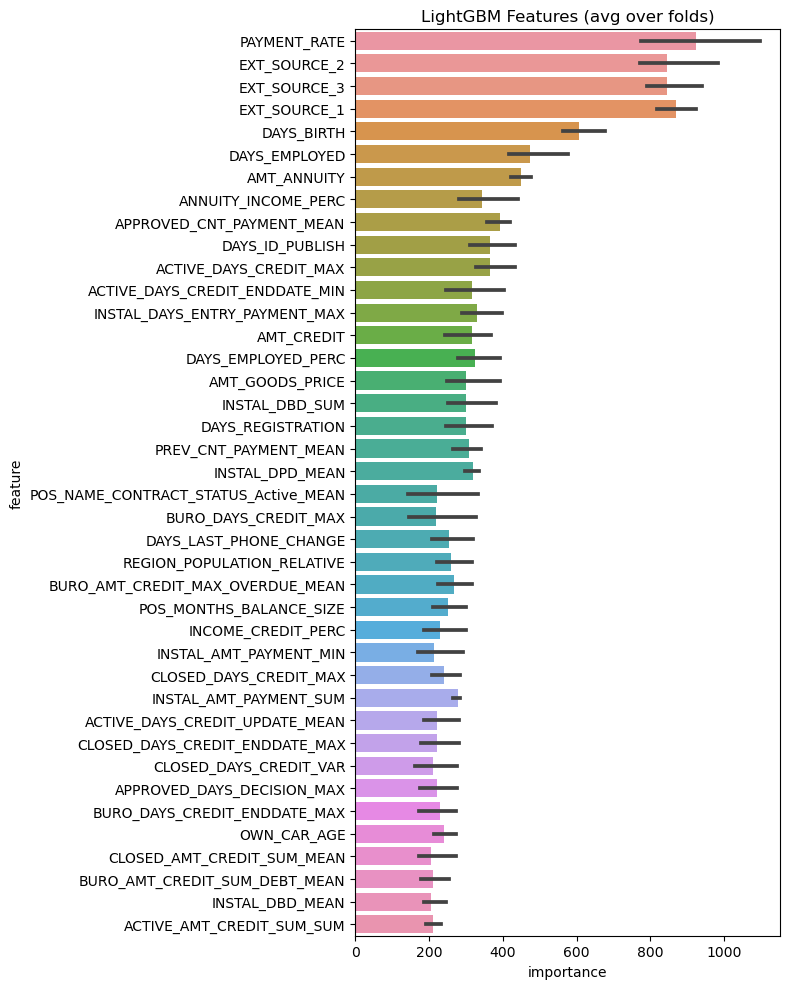

In [22]:
debug =None
num_rows = 10000 if debug else None
df = application_train_test(num_rows)
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
with timer("Process previous_applications"):
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
with timer("Process installments payments"):
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
with timer("Process credit card balance"):
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 3, stratified= False, debug= debug)
        
    



In [23]:
df

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,48739,456221,NaN,1,0,0,0,121500.0,412560.0,17473.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356251,48740,456222,NaN,1,0,1,2,157500.0,622413.0,31909.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356252,48741,456223,NaN,1,1,0,1,202500.0,315000.0,33205.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356253,48742,456224,NaN,0,0,1,0,225000.0,450000.0,25128.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
feat_importance['importance'].describe()

In [24]:
# Valeurs manquantes

taux = (df.isna().sum()/df.shape[0]).sort_values(ascending=True)
taux

index                                    0.000000
OCCUPATION_TYPE_Medicine staff           0.000000
OCCUPATION_TYPE_Private service staff    0.000000
OCCUPATION_TYPE_Realty agents            0.000000
OCCUPATION_TYPE_Sales staff              0.000000
                                           ...   
REFUSED_AMT_DOWN_PAYMENT_MEAN            0.852343
REFUSED_RATE_DOWN_PAYMENT_MIN            0.852343
REFUSED_RATE_DOWN_PAYMENT_MAX            0.852343
REFUSED_AMT_DOWN_PAYMENT_MIN             0.852343
REFUSED_RATE_DOWN_PAYMENT_MEAN           0.852343
Length: 798, dtype: float64

### Selection des features

In [25]:
cols = feat_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
best_features =feat_importance.loc[feat_importance.feature.isin(cols)]

In [26]:
best_features

,feature,importance,fold
5,AMT_CREDIT,244,1
6,AMT_ANNUITY,453,1
7,AMT_GOODS_PRICE,263,1
8,REGION_POPULATION_RELATIVE,239,1
9,DAYS_BIRTH,576,1
...,...,...,...
633,INSTAL_DBD_MEAN,245,3
634,INSTAL_DBD_SUM,381,3
646,INSTAL_AMT_PAYMENT_MIN,291,3
649,INSTAL_AMT_PAYMENT_SUM,283,3


In [27]:
select_feature_df=best_features.sort_values(by="importance", ascending=False)
select_feature=list(select_feature_df['feature'].unique())
select_feature.append('TARGET')
select_feature.append('SK_ID_CURR')

In [28]:
len(select_feature)

42

In [30]:
# Creer un nouveau jeu de données avec les features selectionnés 

new_data= df[select_feature]
new_data

,PAYMENT_RATE,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_1,DAYS_BIRTH,DAYS_EMPLOYED,AMT_ANNUITY,ANNUITY_INCOME_PERC,APPROVED_CNT_PAYMENT_MEAN,DAYS_ID_PUBLISH,...,CLOSED_DAYS_CREDIT_VAR,APPROVED_DAYS_DECISION_MAX,BURO_DAYS_CREDIT_ENDDATE_MAX,OWN_CAR_AGE,CLOSED_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_DEBT_MEAN,INSTAL_DBD_MEAN,ACTIVE_AMT_CREDIT_SUM_SUM,TARGET,SK_ID_CURR
0,0.060749,0.262949,0.139376,0.083037,-9461,-637.0,24700.5,0.121978,24.000000,-2120,...,123956.700000,-606.0,780.0,NaN,63844.500000,49156.200,20.421053,481988.565,1.0,100002
1,0.027598,0.622246,NaN,0.311267,-16765,-1188.0,35698.5,0.132217,10.000000,-291,...,820590.333333,-746.0,1216.0,NaN,69133.500000,0.000,7.160000,810000.000,0.0,100003
2,0.050000,0.555912,0.729567,NaN,-19046,-225.0,6750.0,0.100000,4.000000,-2531,...,421362.000000,-815.0,-382.0,26.0,94518.900000,0.000,7.666667,NaN,0.0,100004
3,0.094941,0.650442,NaN,NaN,-19005,-3039.0,29686.5,0.219900,18.000000,-2437,...,NaN,-181.0,NaN,NaN,NaN,NaN,19.375000,NaN,0.0,100006
4,0.042623,0.322738,NaN,NaN,-19932,-3038.0,21865.5,0.179963,20.666667,-3458,...,NaN,-374.0,-783.0,NaN,146250.000000,0.000,4.590909,NaN,0.0,100007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,0.042354,0.648575,0.643026,NaN,-19970,-5169.0,17473.5,0.143815,24.000000,-3399,...,477960.333333,-683.0,793.0,NaN,93622.500000,111294.000,7.333333,837931.500,NaN,456221
356251,0.051267,0.684596,NaN,NaN,-11186,-1149.0,31909.5,0.202600,17.500000,-3003,...,NaN,-770.0,NaN,NaN,NaN,NaN,6.000000,NaN,NaN,456222
356252,0.105414,0.632770,0.283712,0.733503,-15922,-3037.0,33205.5,0.163978,11.000000,-1504,...,153749.666667,-84.0,-13.0,4.0,526440.375000,4268.700,31.625000,50547.960,NaN,456223
356253,0.055840,0.445701,0.595456,0.373090,-13968,-2731.0,25128.0,0.111680,17.000000,-1364,...,623987.563636,-577.0,980.0,NaN,152999.566364,52511.904,7.275862,2165689.080,NaN,456224


In [45]:
data_clean = new_data[new_data['TARGET'].notnull()]
data_clean.shape

(307507, 42)

### Modelisation avec  HistGradientBoostingClassifier

In [46]:
feats = [f for f in data_clean.columns if f not in ['TARGET','SK_ID_CURR']]

In [32]:

from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve,confusion_matrix
# Classification Report
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score,accuracy_score

import joblib

In [47]:
x=data_clean[feats]
y=data_clean['TARGET']

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2) # 20% des données dans le jeu de test

In [48]:
# Implémenter le model

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from collections import Counter

model_HGBC = Pipeline(steps=[('RobustScaler', RobustScaler()),('HGBClassifier', HistGradientBoostingClassifier(class_weight='balanced'))])

model_HGBC.fit(x_train, y_train)  

Pipeline(steps=[('RobustScaler', RobustScaler()),
                ('HGBClassifier',
                 HistGradientBoostingClassifier(class_weight='balanced'))])

#### GridsearchCV

In [49]:


parameters ={
    'HGBClassifier__learning_rate': (0.01, 0.1, 1, 10),
    'HGBClassifier__max_leaf_nodes': (3, 10, 30,40),
    'HGBClassifier__max_depth' : [25, 50, 75]
    
}


clf = GridSearchCV(model_HGBC, parameters,scoring ='accuracy', cv=5, n_jobs=-1)

clf.fit(x_train, y_train)
print(f"best score {clf.score(x_train, y_train)}")
print(f"best parameters {clf.best_params_}" )


best score 0.7369728257555741
best parameters {'HGBClassifier__learning_rate': 0.1, 'HGBClassifier__max_depth': 75, 'HGBClassifier__max_leaf_nodes': 40}


#### Prediction avec les meilleurs hyperparamètres

In [51]:
best_HGBC = Pipeline(steps=[('RobustScaler', RobustScaler()), 
                              ('HGBClassifier', HistGradientBoostingClassifier(learning_rate=0.1,max_depth=75,max_leaf_nodes=40,class_weight='balanced'))])

In [52]:
# Implémenter notre pipeline 

best_HGBC.fit(x_train, y_train)

Pipeline(steps=[('RobustScaler', RobustScaler()),
                ('HGBClassifier',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                max_depth=75,
                                                max_leaf_nodes=40))])

<AxesSubplot: >

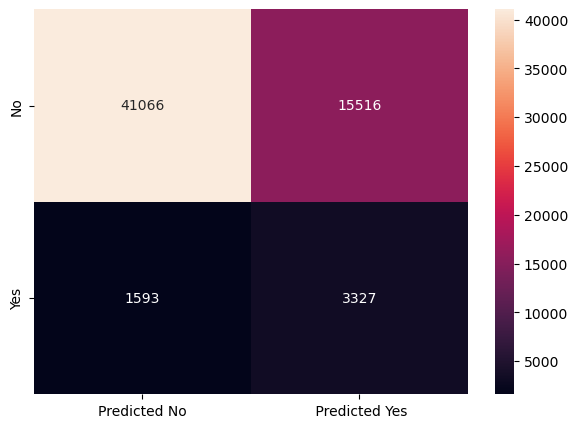

In [53]:
# Prediction

import seaborn as sns 

predict_y = best_HGBC.predict(x_test)


cm=confusion_matrix(y_test,predict_y,labels=[0, 1])

df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["Predicted No"," Predicted Yes"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g')

In [54]:
print(accuracy_score(y_test,predict_y))

0.7218139247504146


In [55]:
print(roc_auc_score(y_test,predict_y))

0.7009990141654978


####  Intéprétabilité du modele

In [56]:
import shap
shap.initjs()

In [57]:
# Creer un objet explicatif

classifier=best_HGBC['HGBClassifier']

In [58]:
# données transformées 

x_train_transfo= best_HGBC['RobustScaler'].fit_transform(x_train)
x_test_transfo= best_HGBC['RobustScaler'].transform(x_test)


In [59]:
classifier_explainer1 = shap.TreeExplainer(classifier,x_train_transfo)

In [60]:
shap_vals = classifier_explainer1.shap_values(x_test_transfo,check_additivity=False)

100%|===================| 61474/61502 [04:26<00:00]        

In [61]:
features=list(data_clean[feats].columns)
features

['PAYMENT_RATE',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'EXT_SOURCE_1',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'AMT_ANNUITY',
 'ANNUITY_INCOME_PERC',
 'APPROVED_CNT_PAYMENT_MEAN',
 'DAYS_ID_PUBLISH',
 'ACTIVE_DAYS_CREDIT_MAX',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
 'AMT_CREDIT',
 'DAYS_EMPLOYED_PERC',
 'AMT_GOODS_PRICE',
 'INSTAL_DBD_SUM',
 'DAYS_REGISTRATION',
 'PREV_CNT_PAYMENT_MEAN',
 'INSTAL_DPD_MEAN',
 'POS_NAME_CONTRACT_STATUS_Active_MEAN',
 'BURO_DAYS_CREDIT_MAX',
 'DAYS_LAST_PHONE_CHANGE',
 'REGION_POPULATION_RELATIVE',
 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'POS_MONTHS_BALANCE_SIZE',
 'INCOME_CREDIT_PERC',
 'INSTAL_AMT_PAYMENT_MIN',
 'CLOSED_DAYS_CREDIT_MAX',
 'INSTAL_AMT_PAYMENT_SUM',
 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN',
 'CLOSED_DAYS_CREDIT_ENDDATE_MAX',
 'CLOSED_DAYS_CREDIT_VAR',
 'APPROVED_DAYS_DECISION_MAX',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'OWN_CAR_AGE',
 'CLOSED_AMT_CREDIT_SUM_MEAN',
 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
 'INSTAL_DBD_MEAN',
 'ACTIVE_AMT_

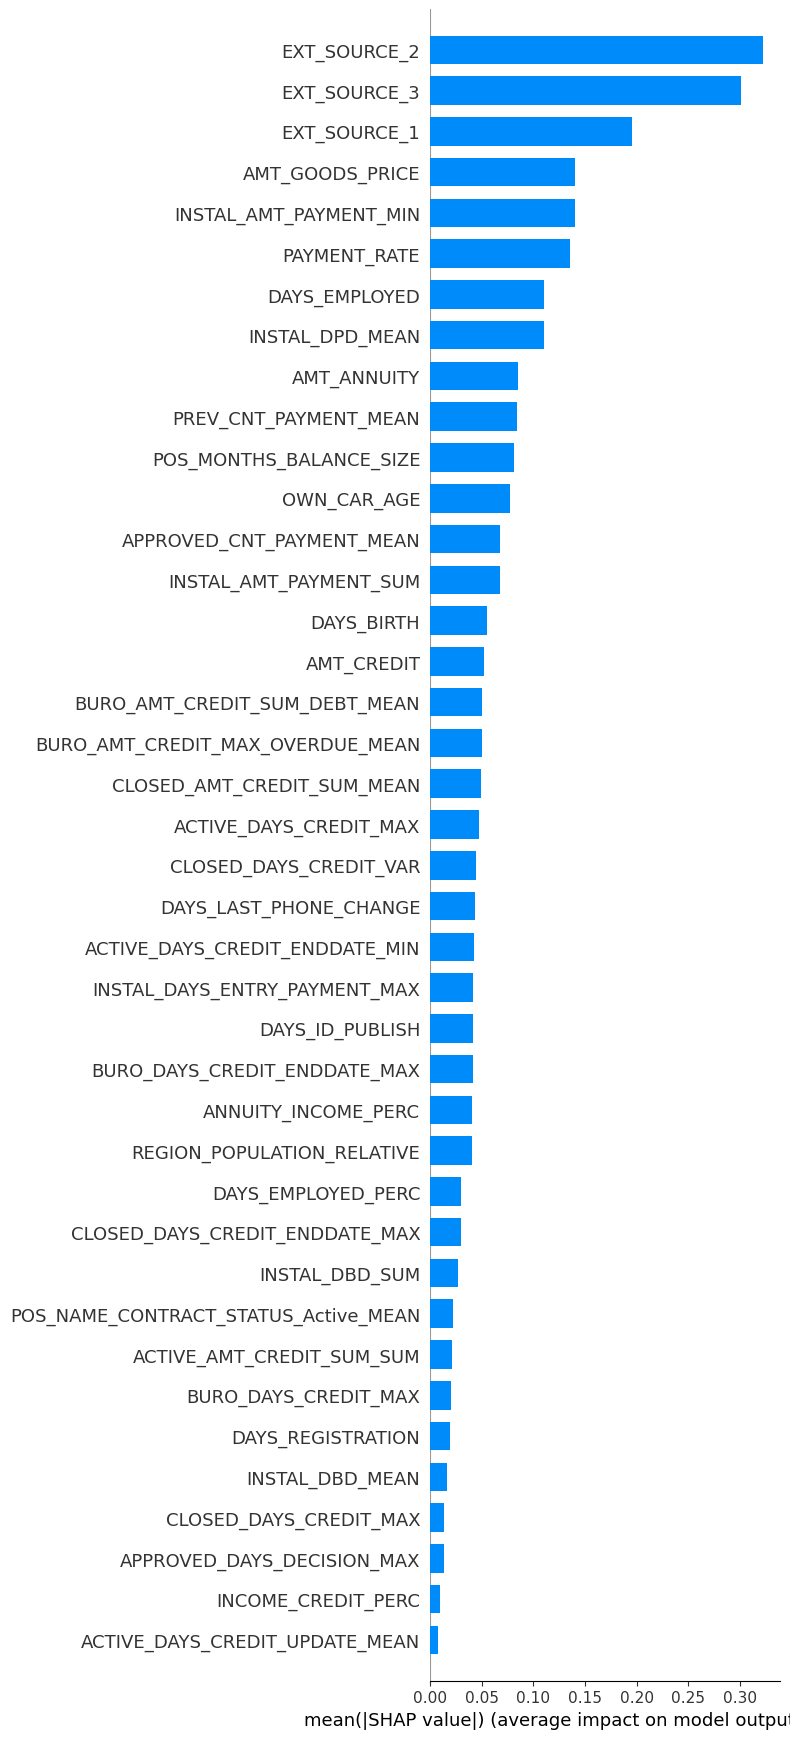

In [62]:
shap.summary_plot(shap_vals,x_test_transfo,plot_type='bar',feature_names=features,max_display=len(features))

In [63]:
# Choix de meilleurs features

best_feature =["EXT_SOURCE_2","EXT_SOURCE_3","EXT_SOURCE_1","AMT_GOODS_PRICE","INSTAL_AMT_PAYMENT_MIN","PAYMENT_RATE","DAYS_EMPLOYED"]

In [64]:
X=data_clean[best_feature]
Y=data_clean['TARGET']


train_X,test_X,train_Y,test_Y = train_test_split(X, Y,test_size=0.2)# 20% des données dans le jeu de test

In [65]:
# Implémenter notre pipeline 
HGBC_best = Pipeline(steps=[('RobustScaler', RobustScaler()), 
                              ('HGBClassifier', HistGradientBoostingClassifier(learning_rate=0.1,max_depth=75,max_leaf_nodes=40,class_weight='balanced'))])
HGBC_best.fit(train_X,train_Y)

Pipeline(steps=[('RobustScaler', RobustScaler()),
                ('HGBClassifier',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                max_depth=75,
                                                max_leaf_nodes=40))])

In [66]:
y_predict = HGBC_best.predict(test_X)

In [67]:
print(accuracy_score(test_Y,y_predict))

0.6994569282299763


In [69]:
# Sauvegarde du dataframe pour l'application
imp =["TARGET","SK_ID_CURR"]+best_feature
imp

['TARGET',
 'SK_ID_CURR',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'EXT_SOURCE_1',
 'AMT_GOODS_PRICE',
 'INSTAL_AMT_PAYMENT_MIN',
 'PAYMENT_RATE',
 'DAYS_EMPLOYED']

In [70]:
df_data=data_clean[imp]
df_data.to_csv('df_projet')

### Sauvegarder le modele 

In [71]:
import joblib

joblib.dump(HGBC_best, 'modele_projet7')

['modele_projet7']